# **Sanity check**
### **05/26/2022**

In [1]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
from glob import glob
import random
import sklearn
from sklearn.model_selection import GridSearchCV

In [2]:
def mahalanobis_transformation(feature_df, flag = "Train"):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    if flag == "Train":
        globals()['feature_mean'] = np.array(feature_df.mean()).reshape(-1, 1).T # 1 * p
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_df.shape[0]
        u, s, vh = np.linalg.svd(cov) # all real numbers
        # w, v = np.linalg.eig(cov) # generate complex numbers
        # theshold for pinv: 1e-15
        s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
        s_pinv_sqrt = np.array(np.zeros(feature_df.shape[1]))
        for i, item in enumerate(np.diag(s_pinv)):
            if item > 0:
                s_pinv_sqrt[i] = np.sqrt(item)
        globals()['sigma_pinv_sqrt'] = u @ np.diag(s_pinv_sqrt) @ u.T
        feature_df_whitened = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    else:
        feature_df_whitened = (feature_df - ones @ globals()['feature_mean']) @ globals()['sigma_pinv_sqrt']
    return feature_df_whitened

def my_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):

    def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_centered.shape[0]
        return cov
    
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        # get slices
        slice_index_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
        for i in np.arange(5):
            slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
            globals()["feature_df_" + str(i + 1)] = feature_df_whitened.iloc[slice_index_dict[i + 1],:]
            globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
            # get sliced cov matrices
            globals()['cov_' + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
        # concatenate 5 cov matrices, weighted by the proportion of classes
        globals()['weight_df'] = label_df["label"].value_counts() / label_df.shape[0]
        weighted_cov = pd.DataFrame(
            data = np.zeros((cov_1.shape[0], cov_1.shape[0])), 
            columns = np.arange(feature_df.shape[1], dtype = int), 
            index = globals()['cov_' + str(1)].index
        )
        for i in np.arange(5):
            print('-------------------------------------------------------------------')
            print(f'Class label {str(i + 1)}:')
            print('COV Mat:')
            print(globals()['cov_' + str(i + 1)])
            if feature_df.shape[1] == 2:
                u, s, vh = np.linalg.svd(globals()['cov_' + str(i + 1)])
                print(f'Eigen values of COV mat: {s}')
                print(f'Eigen values ratio of COV mat: {s[0] / s[1]:8.4f}')
                print(f'(1 - Eigen values of COV mat) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                print(f'(1 - Eigen values of COV mat)^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')
                u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
                print(f'Eigen values of (I - COV mat): {s}')
                print(f'Eigen values ratio of (I - COV mat) : {s[0] / s[1]:8.4f}')
                print(f'(1 - Eigen values of (I - COV mat)) ratio: {(1 - s[0]) / (1 - s[1]):8.4f}')
                print(f'(1 - Eigen values of (I - COV mat))^2 ratio: {((1 - s[0]) / (1 - s[1])) ** 2:8.4f}')

            u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            print(f'(I - V) eigenvalues: {s}')
            u, s, vh = np.linalg.svd((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
            print(f'(I - V)^2 eigenvalues: {s}')
            weighted_cov += weight_df.loc[i + 1] * (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T
        u, s, vh = np.linalg.svd(weighted_cov)
        print('-------------------------------------------------------------------')
        print(f'Weighted sum of (I - V)^2 eigenvalues: {s}')
        print('-------------------------------------------------------------------')
        globals()['directions'] = vh[:,:n_directions]
        feature_df_reduced = feature_df_whitened @ directions
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_reduced = feature_df_whitened @ globals()['directions']
    return feature_df_reduced, feature_df_whitened

def post_process(
    feature_df, 
    label_df, 
    flag = "Train", 
    method = None, 
    add_predictors = False, 
    n_directions = 977
):
    '''
    Implement sufficient dimension reduction methods. 
    SAVE
    Contour regression
    '''
    %xmode plain
    import pandas as pd
    import re
    import os
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    if method:
        feature_df_reduced, feature_df_whitened = method(
            feature_df = feature_df, 
            label_df = label_df, 
            flag = flag,
            n_directions = n_directions
        )
        feature_df_reduced = pd.DataFrame(feature_df_reduced)
        return feature_df_reduced, feature_df_whitened
    else:
        print("No method specified")
        pass


In [4]:
def sanity_check(size = 1000, core_dirs = 1, feature_df_flag = False, feature_df = None, core_distribution = np.random.uniform, redundant_dirs = 1, n_directions = 1, fig_output = True, **kwargs):
    if feature_df_flag == False:
        core_feature_df = pd.DataFrame(data = None)
        for i in np.arange(core_dirs):
            core_feature_df = pd.concat(
                [
                    core_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * 5)
                ], 
                axis = 1
            )
        core_coef = np.random.random(size = core_dirs) * 0.1
        y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
        y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
        redundant_feature_df = pd.DataFrame(data = None)
        for i in np.arange(redundant_dirs):
            redundant_feature_df = pd.concat(
                [
                    redundant_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * (np.random.randint(10) + 5))
                ], 
                axis = 1
            )

    if feature_df_flag == False:
        syncthetic_feature_df_train = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    else:
        syncthetic_feature_df_train = feature_df
    syncthetic_label_df_train = pd.DataFrame(y_train_discrete, columns = ["label"])

    feature_df_reduced, feature_df_whitened = post_process(
        feature_df = syncthetic_feature_df_train, 
        label_df = syncthetic_label_df_train, 
        flag = "Train", 
        method = my_SAVE, 
        n_directions = n_directions
    )
    if fig_output:
        fig = plt.figure(figsize = (4,4), dpi = 270)
        ax = fig.add_subplot(projection = '3d')
        ax.scatter(
            feature_df_whitened.iloc[:,0], 
            feature_df_whitened.iloc[:,1], 
            y_train_discrete.reshape(-1, 1), 
            cmap = "inferno", 
            s = 4, 
            linewidths = 0, 
            edgecolors = None, 
            c = y_train_discrete.reshape(-1, 1))
        ax.set_xlabel("core_x1")
        ax.set_ylabel("redundant_x1")
        ax.set_zlabel("y")
        ax.set_title("Core features: " + str(core_dirs) + " Redundant features: " + str(redundant_dirs))
        plt.show()
        plt.figure(figsize = (4, 3), dpi = 270)
        plt.scatter(core_feature_df.iloc[:,0], y_train_discrete, cmap = "inferno", c = y_train_discrete.reshape(-1, 1))
        plt.xlabel("core_x1")
        plt.ylabel("y")
        plt.title("Sectional View")
        plt.show()
    print('-------------------------------------------------------------------')
    print(f'Directions: \n{directions}')
    return feature_df_reduced, feature_df_whitened, syncthetic_label_df_train


Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (1000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  0.964609  0.003997  0.027428  0.049851 -0.069378 -0.061806  0.049610   
1  0.003997  1.071824 -0.060375  0.041170  0.011160  0.126699  0.009781   
2  0.027428 -0.060375  0.973054  0.068754 -0.045098 -0.048605  0.002355   
3  0.049851  0.041170  0.068754  1.006332 -0.058440 -0.081105  0.040805   
4 -0.069378  0.011160 -0.045098 -0.058440  0.962497 -0.123159 -0.014292   
5 -0.061806  0.126699 -0.048605 -0.081105 -0.123159  0.952152 -0.087075   
6  0.049610  0.009781  0.002355  0.040805 -0.014292 -0.087075  1.037081   
7  0.029068  0.017669  0.069829  0.043805  0.012590  0.088824  0.002191   
8  0.026765  0.035725  0.010433 -0.039732 -0.050987  0.002623 -0.076571   
9 -

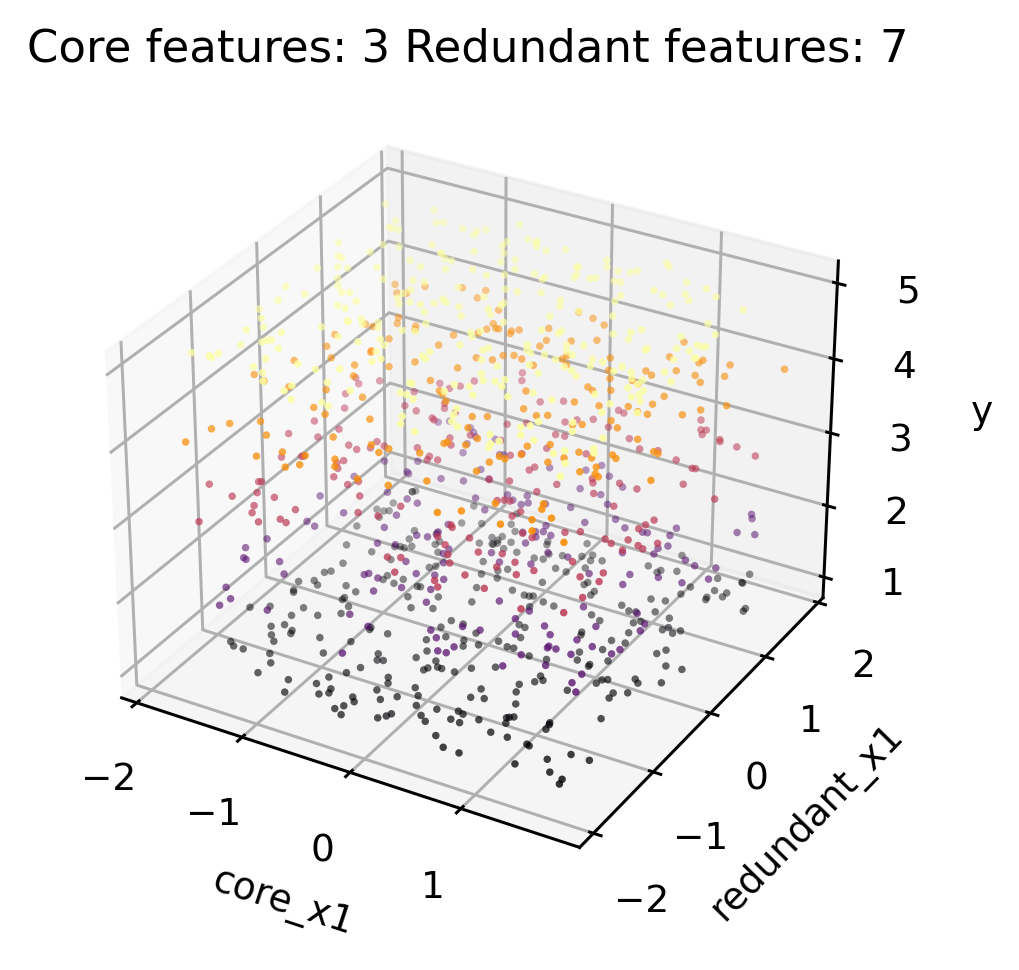

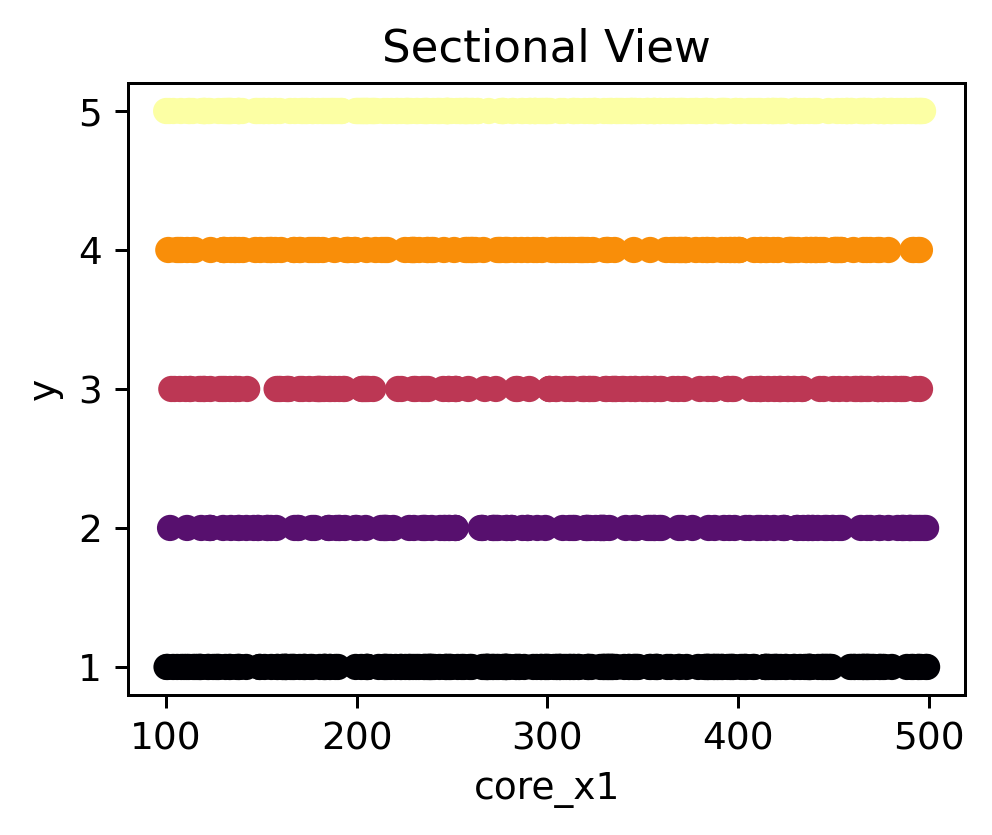

-------------------------------------------------------------------
Directions: 
[[-0.19232336  0.06285766 -0.09986373]
 [-0.2468634  -0.10646848 -0.51220665]
 [ 0.34779998 -0.42825249  0.30676878]
 [ 0.13639182  0.16025729  0.46464824]
 [-0.31481436  0.00270243 -0.29358021]
 [ 0.74431876  0.05986778 -0.45638499]
 [-0.00549491  0.38906579 -0.10288289]
 [ 0.32571204  0.08564707 -0.22347586]
 [ 0.01161718 -0.03091726 -0.22296974]
 [-0.05595218 -0.78254447 -0.1137895 ]]


In [5]:
feature_df_reduced, feature_df_whitened, label_df = sanity_check(core_dirs = 3, redundant_dirs = 7, n_directions = 3, low = 20, high = 100)

In [6]:
basis = directions[:3,:]
print(np.linalg.matrix_rank(basis))
basis

3


array([[-0.19232336,  0.06285766, -0.09986373],
       [-0.2468634 , -0.10646848, -0.51220665],
       [ 0.34779998, -0.42825249,  0.30676878]])

#### Baseline Logistic Regression

In [7]:
def my_lr(feature_df, label_df):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    feature_df_train, feature_df_test, label_df_train, label_df_test = train_test_split(
        feature_df, label_df, 
        test_size = 0.2, 
        shuffle = True, 
        random_state = 42
    )

    lr_params_grid = {
        'C': [1e-5, 0.0001, 0.001, 0.01, 0.1, 0.5, 1,3,5,10], 
        'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
        'penalty': ['elasticnet'],  
        'solver': ['saga'], 
        'random_state': [42], 
        'max_iter': [200, 400, 600, 800, 1000, 2000], 
        'verbose': [0], 
        'n_jobs': [-1], 
        'l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1]
    }

    gs_lr = GridSearchCV(
        estimator = LogisticRegression(), 
        param_grid = lr_params_grid, 
        cv = 5, 
        scoring = 'accuracy', 
        verbose = 0, 
        n_jobs = -1
    )
    gs_lr.fit(feature_df_train, np.array(label_df_train).ravel())
    best_lr = gs_lr.best_estimator_
    lr_pred = best_lr.predict(feature_df_test)
    lr_f1 = f1_score(y_true = label_df_test, y_pred = lr_pred, average = 'macro')
    lr_accu = accuracy_score(y_true = label_df_test, y_pred = lr_pred)
    print('Best params: ')
    print(gs_lr.best_params_)
    print(f'Accuracy: {lr_accu:8.4f}\nF1-score: {lr_f1:8.4f}')
    print('-------------------------------------------------------------------')
    return lr_f1, lr_accu

In [8]:
baseline_f1, baseline_accu = my_lr(feature_df_whitened, label_df)

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 0.01, 'verbose': 0}
Accuracy:   0.2750
F1-score:   0.1414


#### Reduced Logistic Regression

In [9]:
f1, accu = my_lr(feature_df_reduced, label_df)

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.001, 'l1_ratio': 0.01, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.2450
F1-score:   0.0787


#### Learning curve with n_directions

In [34]:
def plot_learning_curve(n_directions_list, f1_score_list, accu_score_list, baseline_f1, baseline_accu, metric_name, x_name, title, x_scale = "linear", save = False, filepath = "", filename = ""):
    '''
    Input: x-axis (e.g. PCA directions kept / n_estimators / max_depth)
           metric_name for y-axis (e.g. misclassification error / crossentropy error / accuracy / f1 score)
           title for this axis
           training + validation score in list
           default in linear scale
           default no saving files, if save is True, then have to specify filename and file path
    Output: inline display of the learning curve
    '''
    import pandas as pd
    import numpy as np  
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib import cm
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    fig,ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
    ax.plot(n_directions_list, f1_score_list, 'o-', label = "F1 score", linewidth = 2)
    ax.plot(n_directions_list, accu_score_list, 'o-', label = "Accuracy score", linewidth = 2)
    ax.axhline(y = baseline_f1, label = "Baseline F1", linestyle = '--', linewidth = 2, c = [255 / 255, 107 / 255, 107 / 255], alpha = 0.7)
    ax.axhline(y = baseline_accu, label = "Baseline Accuracy", linestyle = '--', linewidth = 2, c = [165 / 255, 190 / 255, 204 / 255], alpha = 0.7)
    ax.legend()
    ax.set_xscale(x_scale)
    ax.set_title('Learning Curve: ' + title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(metric_name)
    # ax.hlines(0.3840)
    # ax.hlines(0.2026)
    plt.show()
    if save:
        fig.savefig(filepath + filename + ".png", format = "png")
    pass

In [17]:
# generate feature_df for reuse
def generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 2000, core_distribution = np.random.uniform):
    import pandas as pd
    import numpy as np
    import re
    import os
    import random

    core_feature_df = pd.DataFrame(data = None)
    for i in np.arange(core_dirs):
        core_feature_df = pd.concat(
            [
                core_feature_df, 
                pd.Series(core_distribution(size = size, low = 20, high = 100) * (np.random.randint(10) + 5))
            ], 
            axis = 1
        )
    core_coef = np.random.random(size = core_dirs) * 0.1
    y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
    y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
    redundant_feature_df = pd.DataFrame(data = None)
    for i in np.arange(redundant_dirs):
        redundant_feature_df = pd.concat(
            [
                redundant_feature_df, 
                pd.Series(core_distribution(size = size, low = 20, high = 100) * (np.random.randint(10) + 5))
            ], 
            axis = 1
        )
    synthetic_feature_df = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    synthetic_label_df = pd.DataFrame(y_train_discrete, columns = ["label"])
    return synthetic_feature_df, synthetic_label_df

synthetic_feature_df, synthetic_label_df = generate_synthetic_data(core_dirs = 3, redundant_dirs = 7, size = 2000, core_distribution = np.random.uniform)

In [20]:
n_directions_list = list(np.arange(1, 11, dtype = int))

def lr_learning_curve(synthetic_feature_df, synthetic_label_df, n_directions_list, edr = True):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    f1_list = []
    accu_list = []
    _, synthetic_feature_df_whitened = post_process(
        synthetic_feature_df, 
        synthetic_label_df, 
        flag = "Train", 
        method = my_SAVE, 
        add_predictors = False, 
        n_directions = 1
    )

    if edr:
        # train loop
        for n_direction in n_directions_list:
            print(f'n_directions: {n_direction}')
            globals()['feature_df_reduced_' + str(n_direction)], synthetic_feature_df_whitened = post_process(
                synthetic_feature_df, 
                synthetic_label_df, 
                flag = "Train", 
                method = my_SAVE, 
                add_predictors = False, 
                n_directions = n_direction
            )
            curr_test_f1, curr_test_accu = my_lr(
                feature_df = globals()['feature_df_reduced_' + str(n_direction)], 
                label_df = synthetic_label_df
            )
            f1_list.append(curr_test_f1)
            accu_list.append(curr_test_accu)
    else:
        # train w/ original features -> syncthetic_feature_df -> whitened

        curr_test_f1, curr_test_accu = my_lr(
            feature_df = synthetic_feature_df_whitened, 
            label_df = synthetic_label_df
        )
        f1_list.append(curr_test_f1)
        accu_list.append(curr_test_accu)
    return f1_list, accu_list

f1_list, accu_list = lr_learning_curve(synthetic_feature_df, synthetic_label_df, n_directions_list, edr = True)
baseline_f1, baseline_accu = lr_learning_curve(synthetic_feature_df, synthetic_label_df, n_directions_list, edr = False)

Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.010510 -0.090740 -0.040461  0.049592  1.015608 -0.027721   
6 -0.065814 -0.064404  0.006778  0.026741  0.035335 -0.027721  0.984127   
7 -0.013776  0.036690  0.056250 -0.002577 -0.028378  0.001619 -0.009827   
8 -0.022060  0.080740 -0.043335 -0.023998  0.047571  0.012972 -0.028984   
9 -

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 1e-05, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3025
F1-score:   0.0929
n_directions: 2
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.01

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 1e-05, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3025
F1-score:   0.0929
n_directions: 3
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.01

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'l1_ratio': 1, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3075
F1-score:   0.1513
n_directions: 4
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.0105

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3175
F1-score:   0.1536
n_directions: 5
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.2875
F1-score:   0.1449
n_directions: 6
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.01

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.001, 'l1_ratio': 0, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3225
F1-score:   0.1387
n_directions: 7
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.01

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.001, 'l1_ratio': 0.001, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3100
F1-score:   0.1308
n_directions: 8
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.01, 'l1_ratio': 0.01, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.2925
F1-score:   0.1472
n_directions: 9
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.01, 'l1_ratio': 0.01, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.2875
F1-score:   0.1447
n_directions: 10
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.001, 'l1_ratio': 0.001, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3000
F1-score:   0.1304
Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (2000, 10)
-------------------------------------------------------------------
Class label 1:
COV Mat:
          0         1         2         3         4         5         6  \
0  1.034114 -0.015512  0.011905  0.017816 -0.002739  0.019487 -0.065814   
1 -0.015512  1.008034  0.078223  0.052944  0.027088  0.010510 -0.064404   
2  0.011905  0.078223  1.026232 -0.047398 -0.085712 -0.090740  0.006778   
3  0.017816  0.052944 -0.047398  0.986272 -0.062635 -0.040461  0.026741   
4 -0.002739  0.027088 -0.085712 -0.062635  0.978995  0.049592  0.035335   
5  0.019487  0.010510 -0.0907

/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kangshuoli/miniforge3/envs/env_torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_

-------------------------------------------------------------------
Best params: 
{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga', 'tol': 1e-06, 'verbose': 0}
Accuracy:   0.3050
F1-score:   0.1530


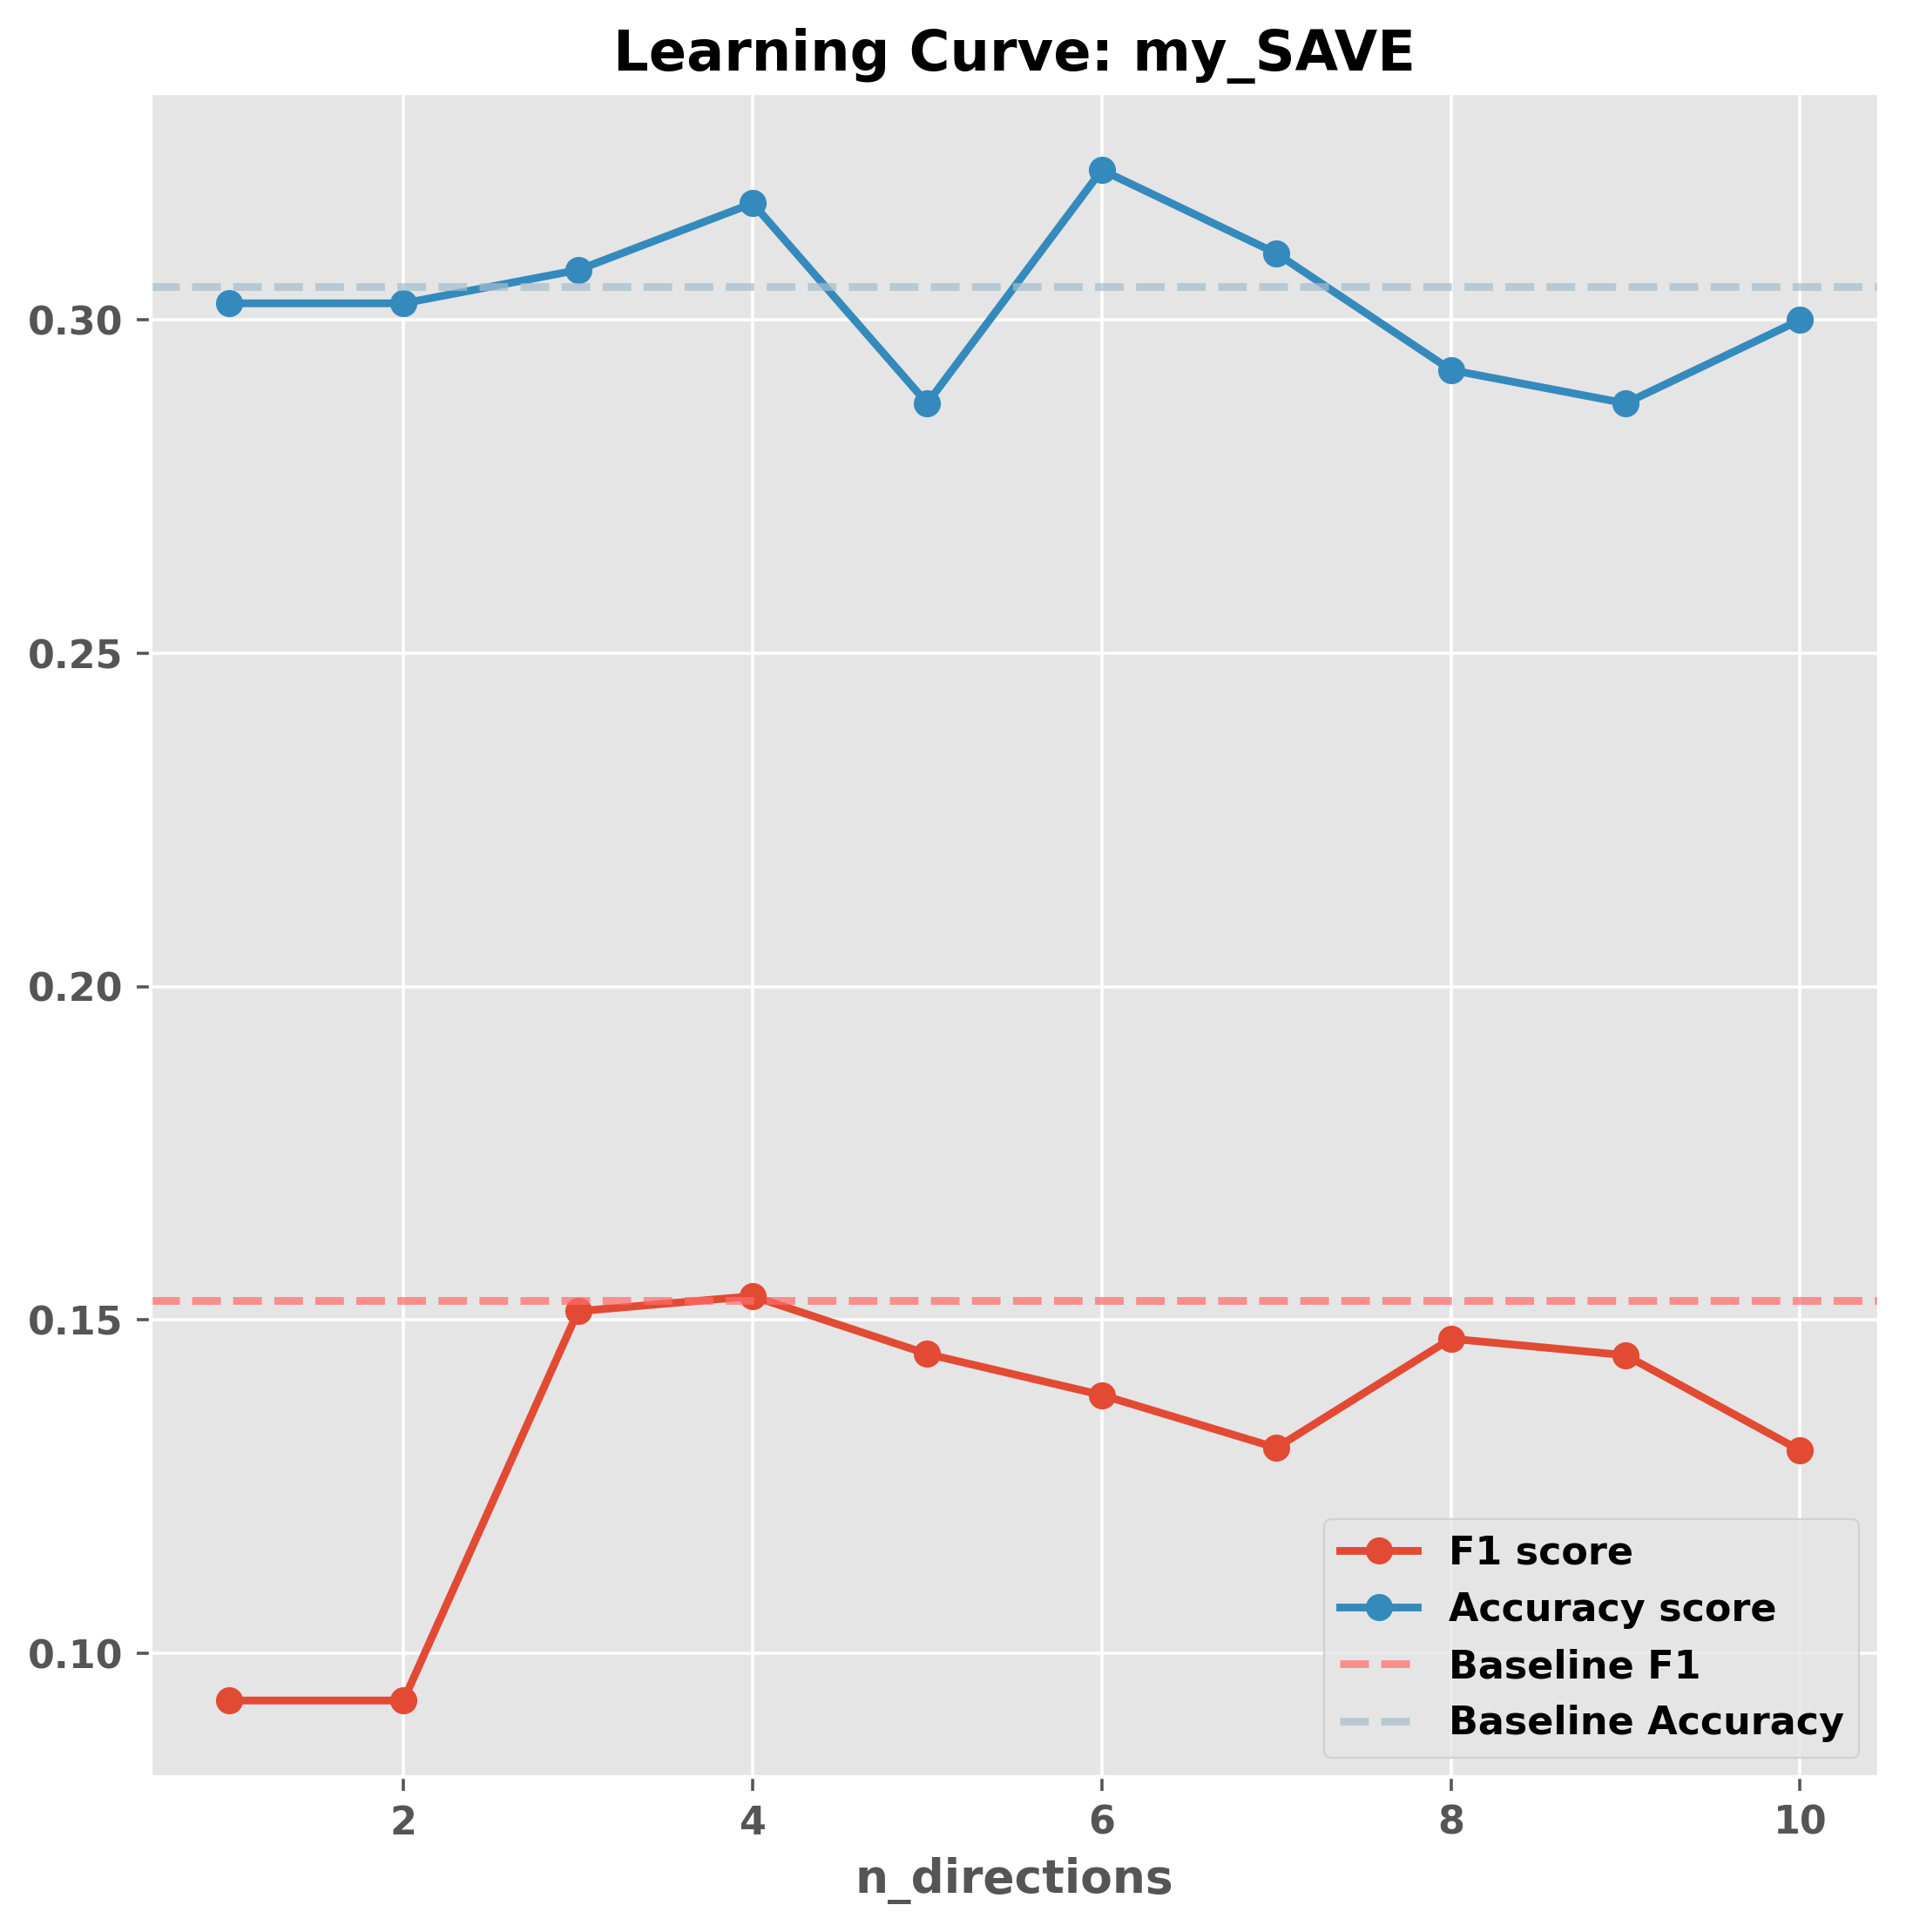

In [36]:
plot_learning_curve(
    n_directions_list = n_directions_list, 
    f1_score_list = f1_list, 
    accu_score_list = accu_list, 
    baseline_f1 = baseline_f1, 
    baseline_accu = baseline_accu,
    metric_name = "", 
    x_name = "n_directions", 
    title = "my_SAVE"
)

In [38]:
pd.DataFrame(mahalanobis_transformation(synthetic_feature_df)).cov()

,0,1,2,3,4,5,6,7,8,9
0,1.000500e+00,0.000000e+00,-3.909940e-17,-5.154012e-17,1.244072e-17,-2.088263e-17,8.175329e-17,-4.220958e-17,-1.395138e-16,3.572263e-16
1,0.000000e+00,1.000500e+00,-3.989916e-16,-5.194000e-16,5.776048e-17,-6.753533e-17,-8.102018e-16,1.058572e-16,-7.064551e-17,-2.544127e-15
2,-3.909940e-17,-3.989916e-16,1.000500e+00,2.523689e-16,4.345365e-16,7.406670e-16,8.246419e-16,3.863287e-16,-1.021916e-17,7.659928e-16
3,-5.154012e-17,-5.194000e-16,2.523689e-16,1.000500e+00,4.842994e-16,8.540498e-17,4.771904e-16,5.882682e-16,-5.811593e-16,3.358994e-16
4,1.244072e-17,5.776048e-17,4.345365e-16,4.842994e-16,1.000500e+00,-6.931257e-17,3.207928e-16,-3.412311e-16,7.882084e-16,-8.068694e-16
5,-2.088263e-17,-6.753533e-17,7.406670e-16,8.540498e-17,-6.931257e-17,1.000500e+00,-3.732215e-16,4.364248e-16,-1.510659e-16,1.866108e-17
6,8.175329e-17,-8.102018e-16,8.246419e-16,4.771904e-16,3.207928e-16,-3.732215e-16,1.000500e+00,-1.466228e-16,1.243628e-15,1.148989e-15
7,-4.220958e-17,1.058572e-16,3.863287e-16,5.882682e-16,-3.412311e-16,4.364248e-16,-1.466228e-16,1.000500e+00,-2.043832e-16,-5.420599e-17
8,-1.395138e-16,-7.064551e-17,-1.021916e-17,-5.811593e-16,7.882084e-16,-1.510659e-16,1.243628e-15,-2.043832e-16,1.000500e+00,-1.636843e-15
9,3.572263e-16,-2.544127e-15,7.659928e-16,3.358994e-16,-8.068694e-16,1.866108e-17,1.148989e-15,-5.420599e-17,-1.636843e-15,1.000500e+00
